# 2D GAN of s1 vs s2

s1 vs s2 is an important relationship for the GAN to understand and to be able to recreate. This notebook creates a GAN which accurately recreates a 2D histogram. It is completed in Google Colab for the extra computing power it offered.


In [1]:
pip install uproot

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/My\ Drive/test_run

/content/gdrive/My Drive/test_run


Import relevant libraries & use uproot to open it.

In [0]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree = uproot.open("outRunNeutron2.root")["dstree"]

## Understand the data

The different variables contained within the tree. This is usually done at the start of every Jupyter notebook to allow me to make sure I have the variables and the types of the variables available. Generally this is good habit and is something I would recommend. 

If you have problems with a variable, I would strongly recommend opening the file in a TBrowser in root.

Some variables are given as lists of lists, and therefore need to be 'unpacked'.

The different variables contained within the tree.

In [5]:
tree.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
r                          (no str

## Getting the s1 and s2 variables

From the list of variables stored in the root file, we can extract the relevant variables we would like to use to create a 2D histogram. Some of these variables may require further manipulation, and this is also done here.

norm1 and norm2 must be calualted by plotting the graph then finding the normalisation to make them both the same order of magnitude. 

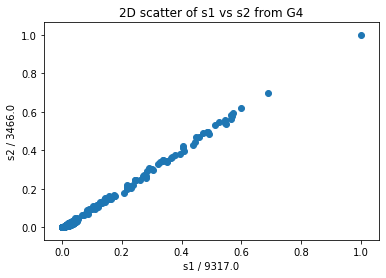

In [6]:
s1 = np.array(tree.array("s1ene"))
s2 = np.array(tree.array("s2ene"))
a1 = s1 / s1.max()
a2 = s2 / s2.max()

train = np.matrix([a1,a2])
train = train.T
train = np.array(train)
plt.scatter(a1, a2)
plt.xlabel(f"s1 / {round(s1.max())}")
plt.ylabel(f"s2 / {round(s2.max())}")
plt.title("2D scatter of s1 vs s2 from G4")
plt.show()

We then set the number of training examples and the size of the noise. In this case, I set the noise size to 1000, thinking it had to be the same as the training data. However this is not the case, as the generator will transform the noise data into the appropriate number of points. 

Something that may be interesting to explore later is the effect of **varying the size of the noise** 

In [0]:
num_train = int(1e4)
noise_size = 1000
epochs     = 2000
batch_size = 1000

## Creation of the GAN

After setting some variables, the GAN is created. Generally there is no 'official documentation' on the correct setup of either the generator or disciminator. However the output of the disciminator should be a softmax, so it outputs a probability of the point being real/fake.

Binary Crossentropy is used to compare a probability (probaility image is real) with a 0,1 which is if it is real or fake. 

The generator is trying to maximise this, and make the disciminator bad at telling the difference, whilst the disciminator is trying to minimise this. 

A simple overview is found on this website: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [8]:
#  Create GAN

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from keras.models     import Model, Sequential
from keras.optimizers import Adam

#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(50, activation="relu", input_shape=(2,)))
#Input shape would be number of parameters
d.add(Dense(50, activation="relu"))
d.add(LeakyReLU(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(50, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(50, activation="relu"))
g.add(BatchNormalization())
#THe number of ourputs here should be the number of dimensions
g.add(Dense(2, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.







Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                50050     
__________________________

In [0]:
def noisegenerator(batch_size, noise_size):
    return np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator loss: 0.69549584
Discriminator acc: 0.254


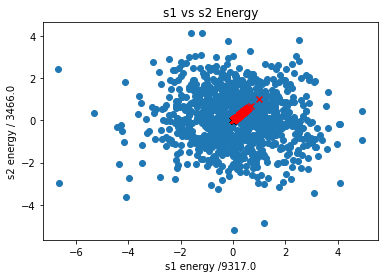

Discriminator loss: 0.6010221
Discriminator acc: 0.977


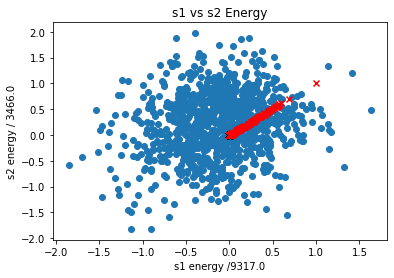

Discriminator loss: 0.5670534
Discriminator acc: 0.937


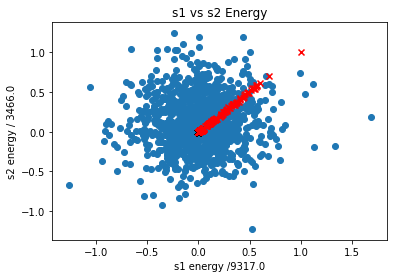

Discriminator loss: 0.55750155
Discriminator acc: 0.9015


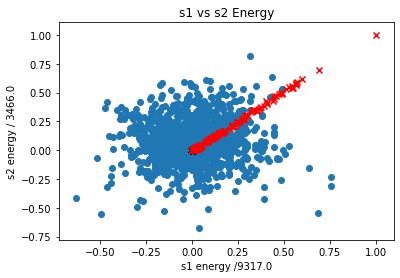

Discriminator loss: 0.53757226
Discriminator acc: 0.891


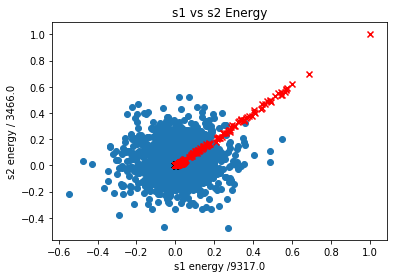

Discriminator loss: 0.5388393
Discriminator acc: 0.869


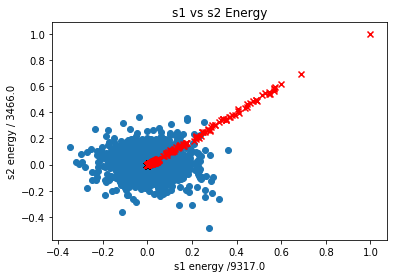

Discriminator loss: 0.52270573
Discriminator acc: 0.885


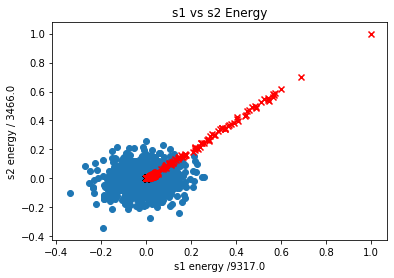

Discriminator loss: 0.52476686
Discriminator acc: 0.8855


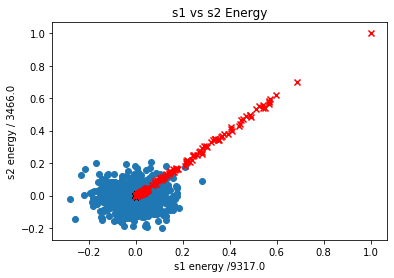

Discriminator loss: 0.51987034
Discriminator acc: 0.891


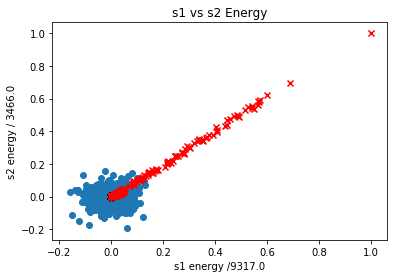

Discriminator loss: 0.48747262
Discriminator acc: 0.9235


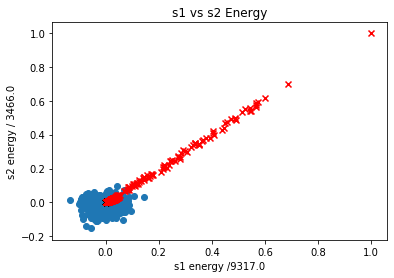

Discriminator loss: 0.5044396
Discriminator acc: 0.8935


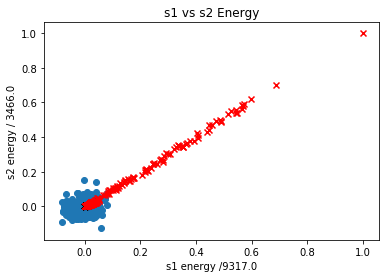

Discriminator loss: 0.44008577
Discriminator acc: 0.9275


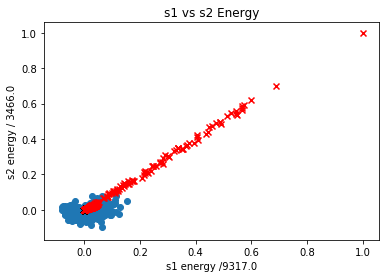

Discriminator loss: 0.5052782
Discriminator acc: 0.9325


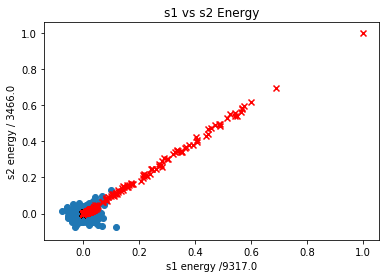

Discriminator loss: 0.52913153
Discriminator acc: 0.829


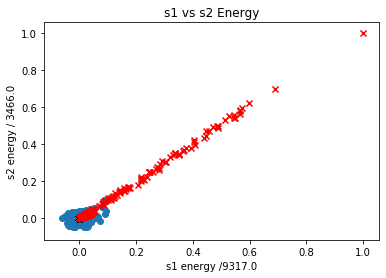

Discriminator loss: 0.53900945
Discriminator acc: 0.885


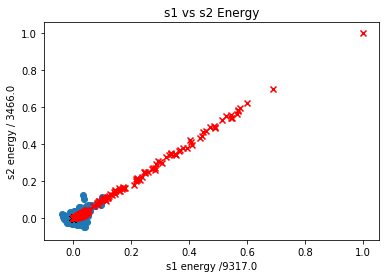

Discriminator loss: 0.4672015
Discriminator acc: 0.907


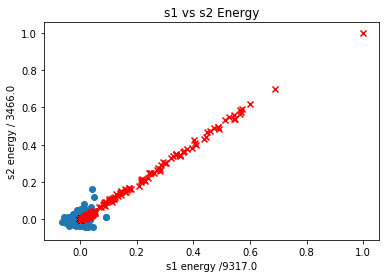

Discriminator loss: 0.5626892
Discriminator acc: 0.8285


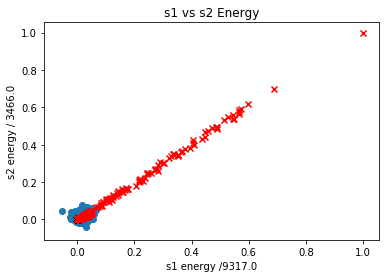

Discriminator loss: 0.6060557
Discriminator acc: 0.856


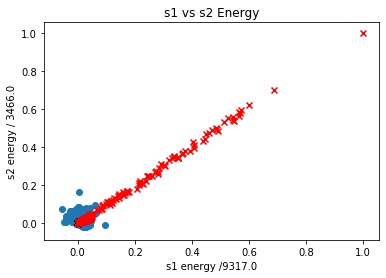

Discriminator loss: 0.6358619
Discriminator acc: 0.7515


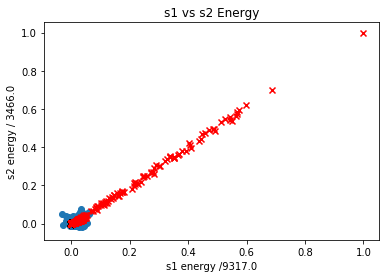

Discriminator loss: 0.6230928
Discriminator acc: 0.847


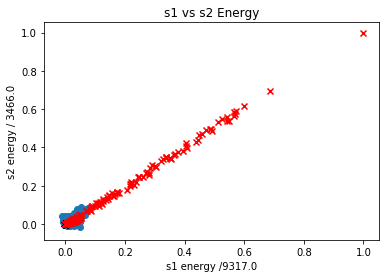

Discriminator loss: 0.5825555
Discriminator acc: 0.8515


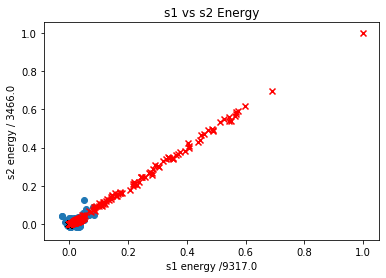

In [10]:
import tensorflow as tf
epochs_saved = []
acc = []
epoch_no = []
for e in range(epochs) :
    noise  = noisegenerator(batch_size, noise_size)

    batch_DS = train[np.random.choice(train.shape[0], batch_size, replace=True), :]
    #fake data made from predicting noise
    gen_DS   = g.predict(noise).reshape(batch_size, 2)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)

        
    noise  = noisegenerator(batch_size, noise_size)
    d.trainable = False
    gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = noisegenerator(batch_size, noise_size)
        gen_DS = g.predict(noise)
        dis_loss, dis_acc = d.train_on_batch(X, Y)
        print("Discriminator loss: " + str(dis_loss))
        print("Discriminator acc: " + str(dis_acc))
        #print("Generator: " + gan.train_on_batch(noise, real_label))
        epoch_no.append(e)
        acc.append(d_acc)
        #x, y = np.hsplit(gen_DS, 2)
        x = np.asarray(gen_DS)[:,0]
        y = np.asarray(gen_DS)[:,1]
        plt.scatter(x, y)
        plt.scatter(a1, a2, c = 'red', marker= 'x')
        plt.xlabel(f"s1 energy /{round(s1.max())}")
        plt.ylabel(f"s2 energy / {round(s2.max())}")
        plt.title("s1 vs s2 Energy")
        plt.show()
        epochs_saved.append(e+1)

## Plotting Discriminator Accuracy

As the generator gets better at fooling the disciminator, the accuracy of the disciminator should decrease, as it finds it harder to tell the difference.

Text(0.5, 1.0, 'Accuracy Function')

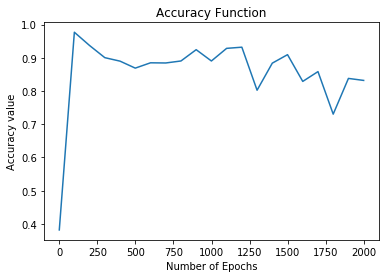

In [11]:
plt.plot(epoch_no,acc)
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy value")
plt.title("Accuracy Function")

## Checking 1D distributions

By learning 2D distributions, the 1D distributuon of s1 and s2 sepearately should also have been learnt. This is checked below, and uses a custom loss function which siply sums the differences in the sizes of the bins of the real and generated graphs.

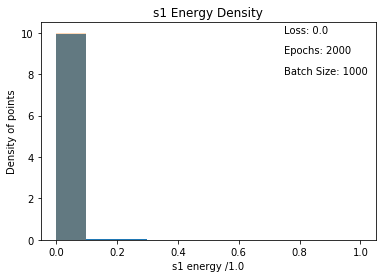

In [12]:
s1_true = plt.hist(a1, density = True,range = (0,1), bins = 10)
s1_gen = plt.hist(x, density = True,range = (0,1), bins = 10, alpha = 0.3)
s1_diff = s1_true[0] - s1_gen[0]

sum_s1_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])

plt.text(0.75,10,f"Loss: {round(sum_s1_diff)}")
plt.text(0.75,9,f"Epochs: {epochs}")
plt.text(0.75,8,f"Batch Size: {batch_size}")
plt.xlabel(f"s1 energy /{round(a1.max())}")
plt.ylabel("Density of points")
plt.title("s1 Energy Density")
plt.show()


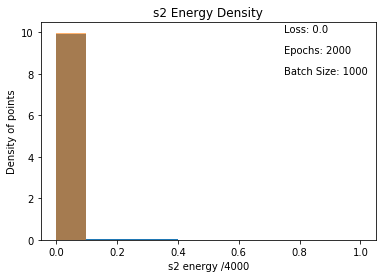

In [13]:
train_DS2 = a2
s2_true = plt.hist(a2, density = True,range = (0,1), bins = 10)
s2_gen = plt.hist(y, density = True,alpha = 0.6,range = (0,1), bins = 10)
plt.xlabel(f"s2 energy /{round(a2.max())}")
plt.ylabel("Density of points")
plt.title("Distribution of s2 Energy")
s2_diff = s2_true[0] - s2_gen[0]

sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s2_diff += abs(s2_diff[i])


plt.text(0.75,10,f"Loss: {round(sum_s2_diff)}")
plt.text(0.75,9,f"Epochs: {epochs}")
plt.text(0.75,8,f"Batch Size: {batch_size}")
plt.xlabel("s2 energy /4000")
plt.ylabel("Density of points")
plt.title("s2 Energy Density")
plt.show()

In [14]:
s1_diff = s1_true[0] - s1_gen[0]
s2_diff = s2_true[0] - s2_gen[0]
sum_s1_diff = 0
sum_s2_diff = 0
for i in range(len(s1_diff)):
  sum_s1_diff += abs(s1_diff[i])
  sum_s2_diff += abs(s2_diff[i])

print("s1 difference is: " + str(sum_s1_diff))
print("s2_difference is: " + str(sum_s2_diff))

s1 difference is: 0.15999999605119267
s2_difference is: 0.1331428543393106
